## Imports

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel, RandomForestReg, RnnDlModel_test 
from bitcoin_deep_learning.trainer import read_result, cv_train
from bitcoin_deep_learning.cross_val import get_cross_XY
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting data

In [2]:
#train_df = ApiCall().get_raw_glassnode_data()
#read_local(data='train')#.drop(columns = '[%]_Bitcoin_growth_rate_on_Horizon=7')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:35<00:00,  1.30s/it]


In [14]:
ApiCall().data_to_csv(train_df, name = 'all_data.csv')

,date,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,...,[$]_[BSB]_Exchange_Net_Position_Change_-_All_Exchanges,[//]_[BSB]_Realized_Profit/Loss_Ratio,[$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL),[$]_[BSB]_Realized_Price,[%]_[BSB]_Price_Drawdown_from_ATH,[//]_[AV]_Market_Value_to_Realized_Value_Ratio_(MVRV),[//]_[AV]_Puell_Multiple,[//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7
0,2011-09-16,1.036434e+13,439,1.418819,7282650.00,5950.00,14298,508,6090,494042,...,74.789093,0.130762,-1.121131e+05,6.124551,-0.849159,0.785527,0.683785,0.000378,4.811000,NaN
1,2011-09-17,1.161376e+13,438,1.429329,7289350.00,6700.00,12877,455,5320,494415,...,69.740065,0.173719,-4.204596e+04,6.118551,-0.850611,0.778730,0.766186,0.000198,4.764700,NaN
2,2011-09-18,1.363396e+13,437,1.441211,7297250.00,7900.00,14074,349,5828,494962,...,30.148647,0.387620,-2.634601e+04,6.113585,-0.835764,0.856819,0.913495,0.000374,5.238233,NaN
3,2011-09-19,1.113934e+13,436,1.452215,7303600.00,6350.00,15826,454,6526,495218,...,38.196675,0.293976,-5.499725e+04,6.105355,-0.828724,0.894751,0.782018,0.000514,5.462771,NaN
4,2011-09-20,1.214578e+13,435,1.462380,7310600.00,7000.00,21668,422,8005,499994,...,36.377675,0.853582,-1.131709e+04,6.104715,-0.808281,1.001652,0.981353,0.001478,6.114797,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,2022-03-05,1.686245e+20,785,108708.531831,18975393.75,768.75,810397,439,225198,40364804,...,4759.246983,0.553335,-1.122980e+08,24156.072349,-0.426605,1.631741,0.697401,0.000304,39416.462688,0.009345
3824,2022-03-06,1.789926e+20,784,108870.777114,18976212.50,818.75,776309,543,206985,40386891,...,1764.382396,0.748933,-6.607873e+07,24153.231574,-0.441048,1.590827,0.740453,0.000430,38423.618936,0.018275
3825,2022-03-07,2.033926e+20,783,108875.720822,18977137.50,925.00,918501,458,255293,40390661,...,-4241.836732,0.728642,-1.721240e+08,24144.851252,-0.446940,1.574607,0.821679,0.001009,38018.649505,-0.136405
3826,2022-03-08,2.023772e+20,782,108943.145857,18978062.50,925.00,956336,358,255623,40368448,...,-13461.316658,1.099048,3.514617e+07,24147.412247,-0.436645,1.603745,0.830735,0.000851,38726.302102,-0.145170


In [9]:
train_df.columns

Index(['date', '[AVG]_[NH]_mean_hash_rate', '[+]_[NH]_Days_Till_Halving',
       '[//]_[AV]_Stock-to-Flow_Ratio', '[+]_[NH]_Circulating_Supply',
       '[+]_[NH]_Issuance', '[+]_[NH]_Number_of_Active_Addresses',
       '[+]_[NH]_Mean_Block_Interval', '[+]_[NH]_Number_of_Transactions',
       '[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.01',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.1',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_1',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_10',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_100',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_1k',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k',
       '[%]_[BSB]_Percent_of_Supply_Last_Active_1+_Years_Ago',
       '[//]_[BSB]_Realized_HODL_Ratio',
       '[AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL)',
       '[//]_[BSB]_Liveliness',
       '[%]_[BSB]_Percent_Balance_on_Exchanges_-_All_

In [23]:
(train_df.shape[0] - (30*(12+3)+6)) // 30

112

In [31]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY(train_df, data=None, verbose = 2)

The set is being split in 112 folds


In [32]:
np.array(X_train_list).shape

(113, 263, 90, 32)

In [17]:
np.array(Y_test_list).shape

(32, 90)

In [37]:
train_df.dtypes

date                                                      datetime64[ns]
[AVG]_[NH]_mean_hash_rate                                        float64
[+]_[NH]_Days_Till_Halving                                         int64
[//]_[AV]_Stock-to-Flow_Ratio                                    float64
[+]_[NH]_Circulating_Supply                                      float64
[+]_[NH]_Issuance                                                float64
[+]_[NH]_Number_of_Active_Addresses                                int64
[+]_[NH]_Mean_Block_Interval                                       int64
[+]_[NH]_Number_of_Transactions                                    int64
[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance               int64
[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.01                   int64
[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.1                    int64
[+]_[NH]_Number_of_Addresses_with_Balance_≥_1                      int64
[+]_[NH]_Number_of_Addresses_with_Balance_≥_10     

## Ploting models

### Plotting prediction per folds

In [33]:
def plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, model):
    fig, axs = plt.subplots(nrows = len(X_train_list), ncols = 4, figsize = (25,200))
    scores = []
    for k in range(len(X_train_list)): #range(5):#
        X_train, y_train, X_test, y_test = X_train_list[k], Y_train_list[k], X_test_list[k], Y_test_list[k]
        #intuition too much regularization on the lasso
        model.set_model()
        y_pred = model.run(X_test, X_train, y_train)
        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)
        axs[k, 0].plot(y_test, label = 'test')
        axs[k, 0].plot(y_pred, color = 'r', label = 'pred')
        axs[k, 0].set_title('Fitting of y_test, y_pred')
        axs[k, 0].set_ylabel('Price growth rate 7 days')
        axs[k, 0].set_xlabel('Fold sequence length in days')
        axs[k, 0].legend(loc='upper right')
        axs[k, 1].plot(y_train, label = 'train', color = 'g')
        axs[k, 1].set_title('Evolution of the y_train')
        axs[k, 1].set_ylabel('Price growth rate 7 days')
        axs[k, 1].set_xlabel('Fold sequence length in days')
        axs[k, 1].legend(loc='upper right');
        axs[k, 2].plot(model.history.history['mae'], color = 'y', label = 'mae')
        axs[k, 2].plot(model.history.history['val_mae'], color = 'b', label = 'val_mae')
        axs[k, 2].set_title('model mae')
        axs[k, 2].set_ylabel('mae')
        axs[k, 2].set_xlabel('epoch')
        axs[k, 2].legend(['train', 'test'], loc='upper right')
        axs[k, 3].plot(model.history.history['loss'], color = 'y', label = 'mae')
        axs[k, 3].plot(model.history.history['val_loss'], color = 'b', label = 'val_mae')
        axs[k, 3].set_title('model train vs validation loss')
        axs[k, 3].set_ylabel('loss')
        axs[k, 3].set_xlabel('epoch')
        axs[k, 3].legend(['train', 'validation'], loc='upper right')
        if k == 1:
            print(model.model.summary())
        print(f'############### next fold => number {k} ########## ')
    print("Mean absolute error - mean") 
    print(np.array(scores).mean())
    print("Mean absolute error - std") 
    print(np.array(scores).std())
    

### RNN Tuning

#### Tuning RNN

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

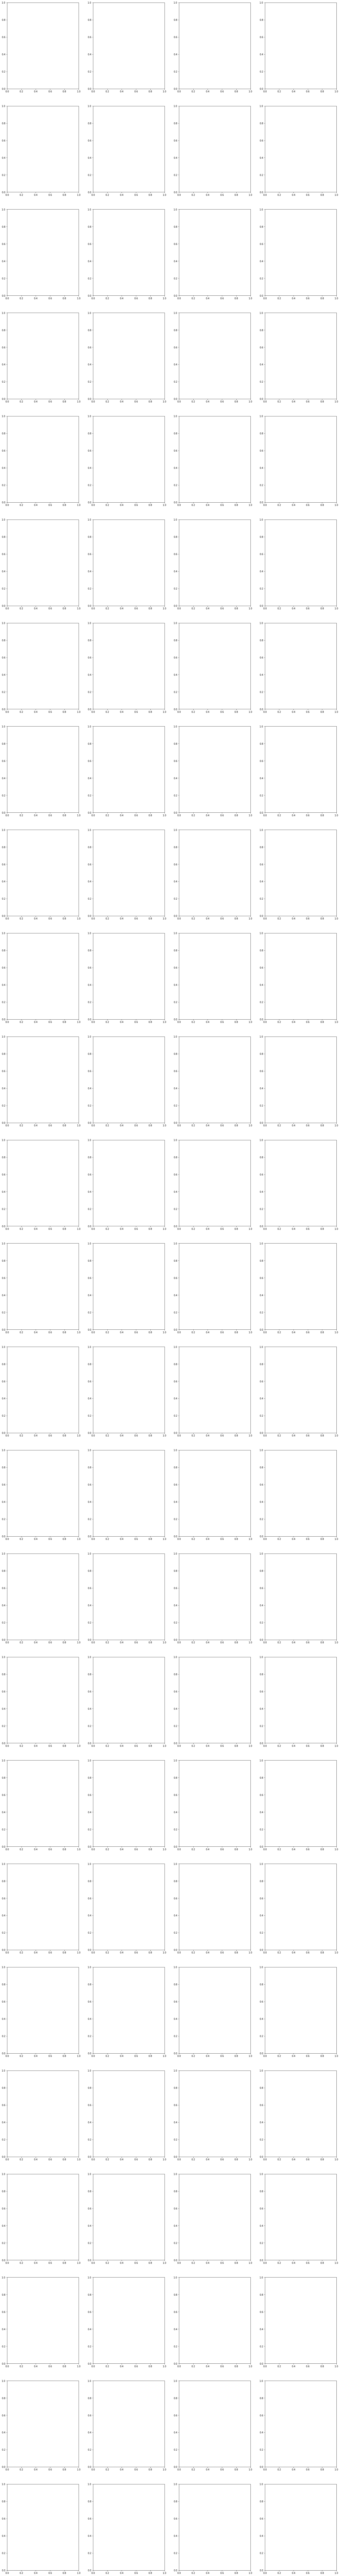

In [38]:
l1_rnn = 0.01653480436240602
l2_rnn = 0.0792386474

plot_predictions_models_all_folds(X_train_list[:25], Y_train_list[:25], X_test_list[:25], Y_test_list[:25], RnnDlModel_test(L1 = l1_rnn, L2 = l2_rnn, epochs = 250, patience = 15))



### Exporting and viewing results

In [43]:
df_result = read_result()
df_result = df_result.sort_values(by="mean_score", ascending = True)
df_result

,name,fold_score,mean_score,min_score,max_score,hyperparams,date
20,LinearReg,"[0.06422, 0.08158, 0.10233, 0.10397, 0.0928, 0...",0.08007,0.03786,0.11896,"{'alpha': 15, 'l1_ratio': 0.0001}",09-03 12:29:18
46,RNN,"[0.08021, 0.07414, 0.15304, 0.09484, 0.09262, ...",0.08496,0.04367,0.15304,"{'L1': 0.09621870580119067, 'L2': 0.0459439662...",09-03 13:50:07
45,RNN,"[0.25442, 0.06626, 0.10818, 0.12145, 0.09141, ...",0.09662,0.04369,0.25442,"{'L1': 0.057297844739236325, 'L2': 0.021727812...",09-03 13:16:23
21,Dummy,"[0.06752, 0.08603, 0.11788, 0.13216, 0.14218, ...",0.11057,0.05455,0.19172,NaN,09-03 12:29:22
42,RNN,"[0.14024, 0.06254, 0.10764, 0.08193, 0.24885, ...",0.13397,0.05175,0.50838,"{'L1': 0.014348080048301116, 'L2': 0.075800478...",09-03 12:58:59
10,LinearReg,"[0.13612, 0.21353, 0.30214, 0.10699, 0.19859, ...",0.16727,0.04825,0.48190,"{'alpha': 0.0146728420498667, 'l1_ratio': 0.002}",09-03 12:24:17
38,LinearReg,"[0.13771, 0.21647, 0.30717, 0.10733, 0.20077, ...",0.16939,0.04850,0.48631,"{'alpha': 0.013972992093995074, 'l1_ratio': 0....",09-03 12:29:47
25,LinearReg,"[0.13809, 0.21718, 0.30844, 0.1074, 0.20131, 0...",0.16991,0.04856,0.48734,"{'alpha': 0.013810108835731945, 'l1_ratio': 0....",09-03 12:29:33
17,LinearReg,"[0.14206, 0.22432, 0.32162, 0.10804, 0.20692, ...",0.17525,0.04917,0.49749,"{'alpha': 0.012252161010179409, 'l1_ratio': 0....",09-03 12:24:24
11,LinearReg,"[0.14258, 0.22526, 0.32338, 0.10813, 0.20769, ...",0.17597,0.04925,0.49874,"{'alpha': 0.012059999245888445, 'l1_ratio': 0....",09-03 12:24:18
